# MSIN0097 Predictive Analytics Individual Assignment

In this assignment, a machine learning problem will be solved using real commercial flight data collected by the US BTS, the Bureau of Transport Statistics. The data comprises flight records (e.g. departure and arrival airport, flight number, distance) of commercial flights departing from and/or arriving in the United States in January 2019 and can be configured and retrieved from the BTS website (BTS, 2019). There is also a description of each variable when configuring the fields for download, which is in the Appendix of this notebook. For this project, the relevant fields have been configured and downloaded, along with an airport coordinate lookup table also provided by the BTS. They have been joined on departure and arrival airport and no further adjustments have been made.

The task in this project is to predict the total taxi time of flights based on all data available prior to the flight (e.g. planned flight time, distance, duration) to solve two problems in flight planning: Fuelling the aircraft with as much taxi fuel as needed for the flight (which can save weight and cost) and improving the scheduled times of flights and thus optimizing the network by knowing in advance how much taxi time is required (reducing delays and saving cost).

The data will first be explored and visualized, then prepared for machine learning, and finally, different supervised regression algorithms will be used and tuned to predict the taxi time with the least possible root mean squared error. The best model is then used to predict the previously unseen test data.

## Loading the data, initial exploration and generating the target variable

In [90]:
import io
from nbformat import current

# word count function from Programming for Business Analytics course
def nb_word_count(nb_path):
    with io.open(nb_path, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')
        word_count = 0
        for cell in nb.worksheets[0].cells:
            if cell.cell_type == "markdown":
                word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    return word_count

print("Word count of markup cells: "+ str(nb_word_count('/Users/niklasmarx/Desktop/Jupyter_Notebooks/Predictive_Analytics/PredictiveAnalytics_IndividualAssignment.ipynb')))

Word count of markup cells: 1964


In [1]:
# importing packages that are needed throughout the code
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Jupyter magic command that allows to present figures inside the notebook directly
%matplotlib inline

# prints out all code results in a cell instead of only the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# read in the data from BTS including coordinate lookup as CSV with pandas
df = pd.read_csv("BTS_Flight_Data_Jan2019.csv")

# display first five lines of the data frame for visual inspection
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_FL_NUM,ORIGIN,ORIGIN_WAC,DEST,DEST_WAC,CRS_DEP_TIME,DEP_TIME_BLK,...,CRS_ARR_TIME,ARR_TIME_BLK,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG
0,1,2,9E,3280,GNV,33,ATL,34,600,0600-0659,...,723,0700-0759,0,0,83.0,300,29.690000,-82.271667,33.636667,-84.427778
1,1,2,9E,3281,MSP,63,CVG,52,1404,1400-1459,...,1709,1700-1759,0,0,125.0,596,44.881944,-93.221667,39.048889,-84.667778
2,1,2,9E,3282,DTW,43,CVG,52,1220,1200-1259,...,1345,1300-1359,0,0,85.0,229,42.212500,-83.353333,39.048889,-84.667778
3,1,2,9E,3283,TLH,33,ATL,34,1527,1500-1559,...,1639,1600-1659,0,0,72.0,223,30.396667,-84.350833,33.636667,-84.427778
4,1,2,9E,3284,ATL,34,FSM,71,1902,1900-1959,...,2005,2000-2059,0,0,123.0,579,33.636667,-84.427778,35.336667,-94.367500


In [3]:
# summary statistics of dataframe of numeric columns
# => notice small number of positive classes on binary variables "CANCELLED" and "DIVERTED"
df.describe()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,ORIGIN_WAC,DEST_WAC,CRS_DEP_TIME,TAXI_OUT,TAXI_IN,CRS_ARR_TIME,CANCELLED,DIVERTED,CRS_ELAPSED_TIME,DISTANCE,ORIGIN_LAT,ORIGIN_LONG,DEST_LAT,DEST_LONG
count,583985.000000,583985.000000,583985.000000,583985.000000,583985.000000,583985.000000,567369.000000,566924.000000,583985.000000,583985.000000,583985.000000,583851.000000,583985.000000,583985.000000,583985.000000,583985.000000,583985.000000
mean,15.960088,3.835626,2537.869334,54.010646,54.011817,1326.266642,18.331121,7.597733,1502.665556,0.028641,0.002219,143.557401,797.742767,36.605864,-94.042935,36.606489,-94.042699
std,8.987942,1.921899,1821.736145,26.155187,26.154263,484.081000,10.895553,5.996932,505.350299,0.166796,0.047056,73.216303,589.999261,5.853339,18.169793,5.852494,18.168811
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,20.000000,31.000000,-14.331667,-176.642500,-14.331667,-176.642500
25%,8.000000,2.000000,979.000000,34.000000,34.000000,917.000000,12.000000,4.000000,1115.000000,0.000000,0.000000,90.000000,363.000000,33.307778,-106.376389,33.307778,-106.376389
50%,16.000000,4.000000,2114.000000,44.000000,44.000000,1320.000000,15.000000,6.000000,1525.000000,0.000000,0.000000,125.000000,640.000000,37.363056,-87.906667,37.363056,-87.906667
75%,24.000000,5.000000,3902.000000,81.000000,81.000000,1730.000000,21.000000,9.000000,1922.000000,0.000000,0.000000,175.000000,1037.000000,40.777222,-80.949167,40.777222,-80.949167
max,31.000000,7.000000,7439.000000,93.000000,93.000000,2359.000000,181.000000,282.000000,2400.000000,1.000000,1.000000,703.000000,4983.000000,71.284722,145.730000,71.284722,145.730000


In [4]:
# display number of non-null values per column and data types
# => notice null values exist in columns "TAXI_OUT", "TAXI_IN" and "CRS_ELAPSED_TIME"
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 22 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   DAY_OF_MONTH       583985 non-null  int64  
 1   DAY_OF_WEEK        583985 non-null  int64  
 2   OP_UNIQUE_CARRIER  583985 non-null  object 
 3   OP_CARRIER_FL_NUM  583985 non-null  int64  
 4   ORIGIN             583985 non-null  object 
 5   ORIGIN_WAC         583985 non-null  int64  
 6   DEST               583985 non-null  object 
 7   DEST_WAC           583985 non-null  int64  
 8   CRS_DEP_TIME       583985 non-null  int64  
 9   DEP_TIME_BLK       583985 non-null  object 
 10  TAXI_OUT           567369 non-null  float64
 11  TAXI_IN            566924 non-null  float64
 12  CRS_ARR_TIME       583985 non-null  int64  
 13  ARR_TIME_BLK       583985 non-null  object 
 14  CANCELLED          583985 non-null  int64  
 15  DIVERTED           583985 non-null  int64  
 16  CR

Looking at the variables contained in the data, the summary statistics and the number of missing values per variable, we see that the data set seems to be mostly coherent. The main variables we should focus on initially are the binary "CANCELLED" and "DIVERTED" variable indicating whether a filght was cancelled or had to divert to another airport. We want to see how many of the flights in the data set were actually cancelled or diverted and possibly remove them if there are not too many, since they will not have representative taxi times (no taxiing for cancelled and possibly unusual taxiing for diverted flights).

In [5]:
# display number of negative and negative classes in binary variables to see distribution
df["CANCELLED"].value_counts()
df["DIVERTED"].value_counts()

0    567259
1     16726
Name: CANCELLED, dtype: int64

0    582689
1      1296
Name: DIVERTED, dtype: int64

In [6]:
# drop the binary variables "CANCELLED" and "DIVERTED"
df = df.drop(["CANCELLED", "DIVERTED"], axis=1)

Since we did not have many cancelled or diverted flights in our 500,000 record dataset and we could drop them, we now want to craete the target variable, which is the total taxi time, consisting of "TAXI_OUT" and "TAXI_IN". We then want to look at its distribution to get an idea of potential outliers and how we can possibly predict the target.

Text(0.5, 0, 'taxi minutes')

Text(0, 0.5, 'number of flights')

Text(0.5, 1.0, 'Number of flights per taxi time')

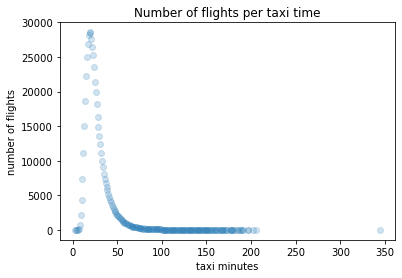

In [7]:
# create target variable out of "TAXI_IN" and "TAXI_OUT"
df["TAXI_TOTAL"] = df["TAXI_OUT"] + df["TAXI_IN"]

# create a data frame with taxi times and number of flight per taxi time to explore distribution
taxi_distribution = df["TAXI_TOTAL"].value_counts()
td = pd.DataFrame(taxi_distribution)
td["TAXI_MINUTES"] = td.index

# plot the number of flights per taxi minutes
plt.scatter(td.TAXI_MINUTES, td.iloc[:,0], alpha=0.2)
plt.xlabel("taxi minutes")
plt.ylabel("number of flights")
plt.title("Number of flights per taxi time")

{'whiskers': [<matplotlib.lines.Line2D at 0x7f8b2f5643a0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f8b2f564a60>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f8b2f564040>],
 'medians': [<matplotlib.lines.Line2D at 0x7f8b2f62f160>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f8b2f62f4c0>],
 'means': []}

Text(0.5, 1.0, 'Boxplot of taxi time distribution')

Text(0, 0.5, 'taxi minutes')

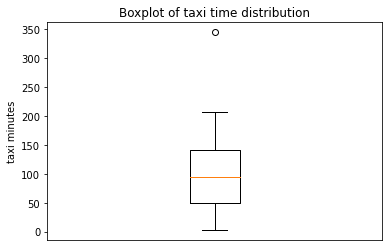

In [8]:
# create boxplot to visualize distribution of taxi times
# => notice one outlier at more than 300 minutes taxi time
plt.boxplot(td.TAXI_MINUTES)
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.title("Boxplot of taxi time distribution")
plt.ylabel("taxi minutes")
plt.show()

The very narrow bell curve with long upper tail with one outlier at approx. 350 minutes we see for the taxi times in our data set show that for many flights, we might be able to predict quite accurate results rather easily (those in the bell curve area between approx. 10 and 60 minutes, whereas predicting the tail of the distribution might be harder. To highlight the more extreme deviations between actual taxi time and the predicted values, we should use the MSE or RMSE (for better scale towards the actual value), which give more weight to more extreme errors.

## Exploring and visualizing features and correlations

Now we will examine how the numerical and categorical features in the data are distributed and correlated, both with other features and the target variable. The first hypothesis we want to test is if taxi times are longer if the overall planned flight time or the flight distance are longer, which might be due to the use of larger airports with longer taxi times for long range flights or due to efficiency reasons where airlines and airports try to reduce the taxi time in relation to the flight time to keep overall travel times shorter.

<AxesSubplot:xlabel='TAXI_TOTAL', ylabel='CRS_ELAPSED_TIME'>

Text(0.5, 0, 'taxi minutes')

Text(0, 0.5, 'planned flighttime')

Text(0.5, 1.0, 'Taxi minutes versus planned flight time and flight distance')

([<matplotlib.axis.XTick at 0x7f8b2f7053d0>,
 [])

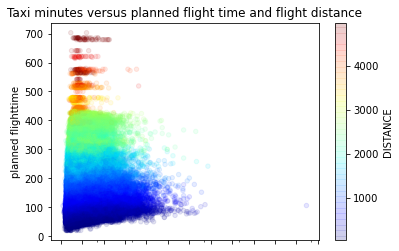

In [9]:
# visualize the taxi time versus planned flight time and distance
# => notice that there is no general trend of longer taxi times for flight with longer duration or distance
df.plot(kind="scatter", x="TAXI_TOTAL", y="CRS_ELAPSED_TIME", alpha=0.1, c="DISTANCE", cmap=plt.get_cmap("jet"), colorbar=True)
plt.xlabel("taxi minutes")
plt.ylabel("planned flighttime")
plt.title("Taxi minutes versus planned flight time and flight distance")
plt.xticks(np.arange(0, 390, step=30), [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330, 360])
plt.show()

While we can reject the previous hypothesis, we can now remove our old "TAXI_IN" and "TAXI_OUT" variables now represented in our target variable and remove the outlier of more than 300 minutes taxi time we previously found.

In a next step, the distributions of all variables in the dataset will be visualized to detect any unusual patterns, separately for numerical and categorical variables. Then, the correlations are explored - first between the target and the features in a list, then in a correlation matrix between all variables and finally in a scatter matrix to discover any non-linear correlations. One hypothesis we want to test in this context is if there is a strong correlation between the airport and taxi times, e.g. some large airports where taxi times are significantly longer than average.

In [10]:
# drop old "TAXI_IN" and "TAXI_OUT" variables and the outlier in taxi time identified in the boxplot above
df = df.drop(["TAXI_OUT", "TAXI_IN"], axis=1)
indexNames = df[df["TAXI_TOTAL"] > 240 ].index
df.drop(indexNames , inplace=True)

array([[<AxesSubplot:title={'center':'DAY_OF_MONTH'}>,
        <AxesSubplot:title={'center':'DAY_OF_WEEK'}>,
        <AxesSubplot:title={'center':'OP_CARRIER_FL_NUM'}>,
        <AxesSubplot:title={'center':'ORIGIN_WAC'}>],
       [<AxesSubplot:title={'center':'DEST_WAC'}>,
        <AxesSubplot:title={'center':'CRS_DEP_TIME'}>,
        <AxesSubplot:title={'center':'CRS_ARR_TIME'}>,
        <AxesSubplot:title={'center':'CRS_ELAPSED_TIME'}>],
       [<AxesSubplot:title={'center':'DISTANCE'}>,
        <AxesSubplot:title={'center':'ORIGIN_LAT'}>,
        <AxesSubplot:title={'center':'ORIGIN_LONG'}>,
        <AxesSubplot:title={'center':'DEST_LAT'}>],
       [<AxesSubplot:title={'center':'DEST_LONG'}>,
        <AxesSubplot:title={'center':'TAXI_TOTAL'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

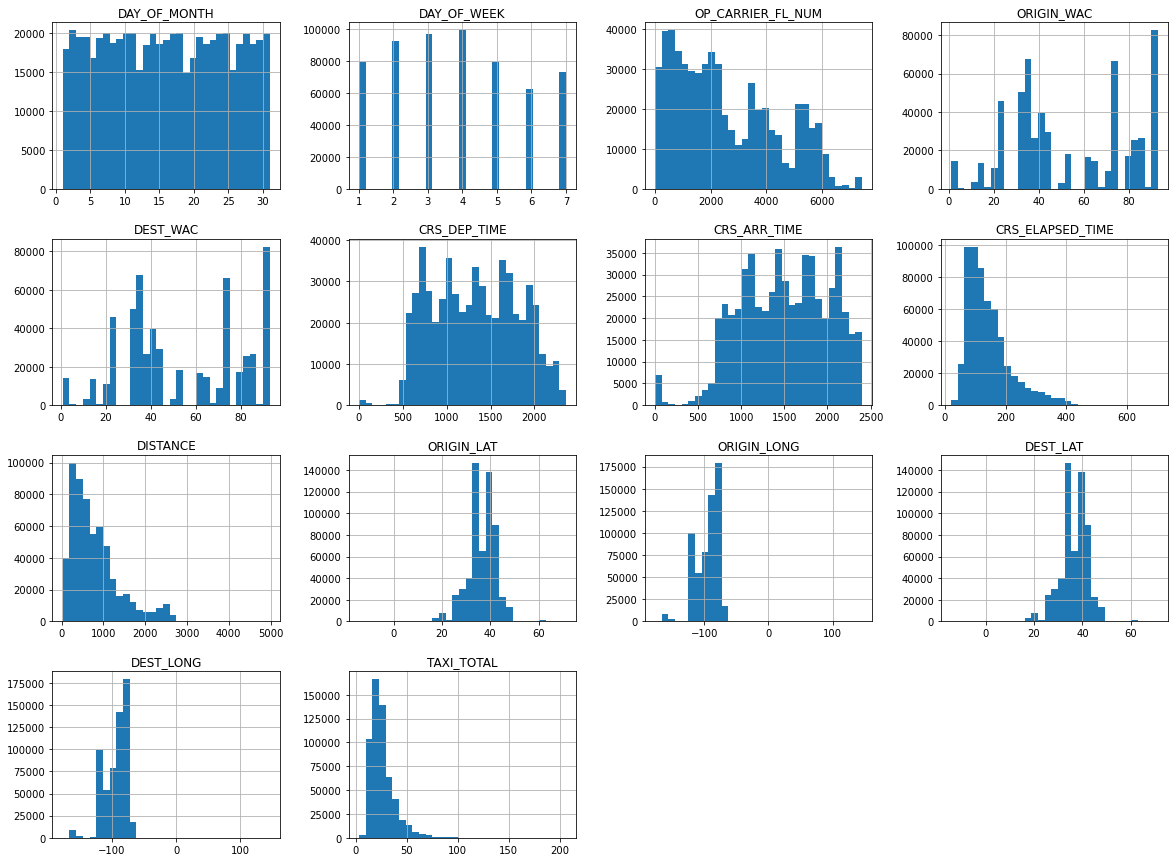

In [11]:
# visualize all numeric variable distributions to get a better idea of their properties 
df.hist(bins=31, figsize=(20,15))
plt.show()

<BarContainer object of 17 artists>

Text(0.5, 0, 'carrier code')

Text(0, 0.5, 'number of flights')

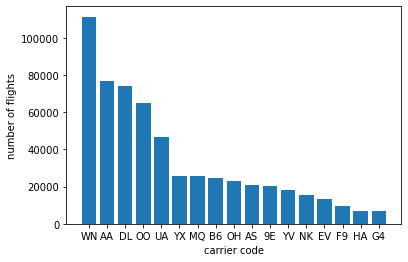

<BarContainer object of 346 artists>

Text(0.5, 0, 'origin code')

Text(0, 0.5, 'number of flights')

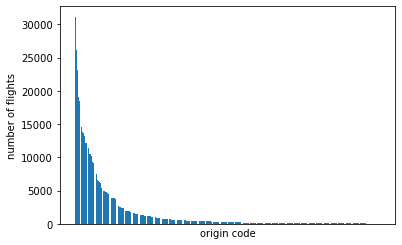

<BarContainer object of 346 artists>

Text(0.5, 0, 'destination code')

Text(0, 0.5, 'number of flights')

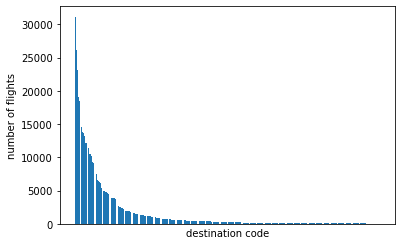

In [12]:
# plot the distribution of values for non-numeric variables
# => notice that origin and destination code show an exponential distribution
carrier_dist = df.OP_UNIQUE_CARRIER.value_counts()
cd = pd.DataFrame(carrier_dist)
cd["CARRIER_FLIGHTS"] = cd.index
plt.bar(cd.CARRIER_FLIGHTS, cd.iloc[:,0])
plt.xlabel("carrier code")
plt.ylabel("number of flights")
plt.show()

origin_dist = df.ORIGIN.value_counts()
od = pd.DataFrame(origin_dist)
od["ORIGIN_FLIGHTS"] = od.index
plt.bar(od.ORIGIN_FLIGHTS, od.iloc[:,0])
plt.xlabel("origin code")
plt.ylabel("number of flights")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

dest_dist = df.DEST.value_counts()
dd = pd.DataFrame(dest_dist)
dd["DEST_FLIGHTS"] = dd.index
plt.bar(dd.DEST_FLIGHTS, dd.iloc[:,0])
plt.xlabel("destination code")
plt.ylabel("number of flights")
plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.show()

In [13]:
# show the correlation of numeric feature variables with target variable "TAXI_TOTAL"
# => notice the highest positive correlation with origin airport coordinates and
# the highest negative correlation with planned departure time
target_feature_correlation = df.corr()
target_feature_correlation["TAXI_TOTAL"].sort_values(ascending=False)

TAXI_TOTAL           1.000000
ORIGIN_LAT           0.155265
ORIGIN_LONG          0.113657
OP_CARRIER_FL_NUM    0.109250
CRS_ELAPSED_TIME     0.102784
DEST_LONG            0.076736
DEST_LAT             0.070380
DISTANCE             0.044943
DAY_OF_MONTH         0.030620
DAY_OF_WEEK         -0.001727
CRS_ARR_TIME        -0.046535
DEST_WAC            -0.051392
ORIGIN_WAC          -0.081946
CRS_DEP_TIME        -0.083026
Name: TAXI_TOTAL, dtype: float64

<AxesSubplot:>

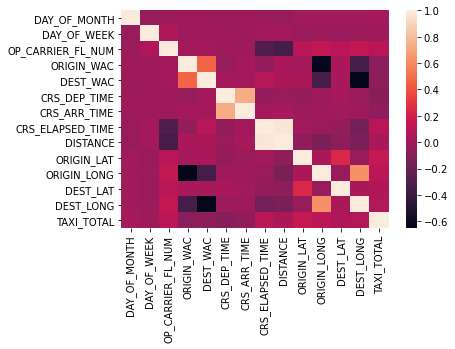

In [14]:
import seaborn as sns

# visualize the correlations between variables with heatmap
# => notice that the strongest negative correlation between features is between World Area Codes and Coordinates
# and the strongest positive correlation is between distance and elapsed time
sns.heatmap(target_feature_correlation, 
        xticklabels=target_feature_correlation.columns,
        yticklabels=target_feature_correlation.columns)


array([[<AxesSubplot:xlabel='DAY_OF_MONTH', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='DAY_OF_WEEK', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='OP_CARRIER_FL_NUM', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='ORIGIN_WAC', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='DEST_WAC', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='CRS_DEP_TIME', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='CRS_ARR_TIME', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='CRS_ELAPSED_TIME', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='DISTANCE', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='ORIGIN_LAT', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='ORIGIN_LONG', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='DEST_LAT', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='DEST_LONG', ylabel='DAY_OF_MONTH'>,
        <AxesSubplot:xlabel='TAXI_TOTAL', ylabel='DAY_OF_MONTH'>],
       [<AxesSubplot:xlabel='DAY_OF_MONTH', ylabel='DAY_OF_WE

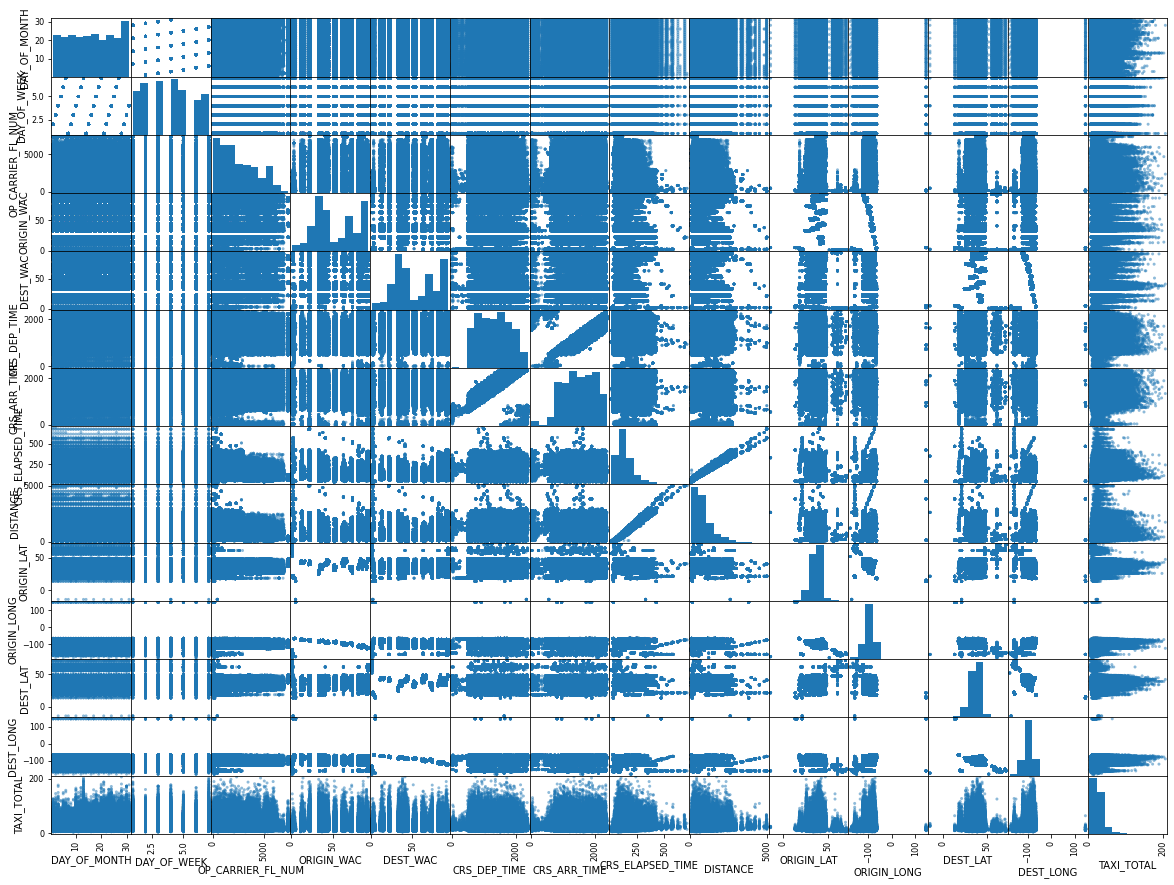

In [15]:
# visualize correlations in a scatter matrix
# => notice that there are few linear relationships, most prominently between distance and elapsed time
from pandas.plotting import scatter_matrix
scatter_matrix(df, figsize=(20,15))
plt.show()

Text(0.5, 1.0, 'Taxi minutes per carrier code')

Text(0.5, 1.0, 'Taxi minutes per origin code')

Text(0.5, 1.0, 'Taxi minutes per destination code')

[Text(27.0, 0.5, 'Taxi minutes')]

[Text(27.0, 0.5, 'Taxi minutes')]

[Text(27.0, 0.5, 'Taxi minutes')]

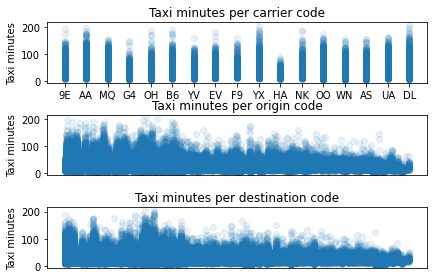

In [16]:
# plot categorical features vs target variable
fig, ax = plt.subplots(3)

fig.tight_layout()
ax[0].set_title("Taxi minutes per carrier code")
ax[0].scatter(df.OP_UNIQUE_CARRIER, df.TAXI_TOTAL, alpha=0.1)
ax[1].set_title("Taxi minutes per origin code")
ax[1].scatter(df.ORIGIN, df.TAXI_TOTAL, alpha=0.1)
ax[1].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax[2].set_title("Taxi minutes per destination code")
ax[2].scatter(df.DEST, df.TAXI_TOTAL, alpha=0.1)
ax[2].tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)

for ax in ax.flat:
    ax.set(ylabel="Taxi minutes")

Apart from the few observations on distributions and correlations made in the code and some obvious relationships (e.g. a correlation between departure and arrival time or flight time and distance), we do not observe many linear or non-linear patterns that might be important to observe for generating ML models. However, we can reject the hypothesis that some airports have extraordinarily high average taxi times, which should thus not be of further concern here. An important observation we make, however, is that the number of flights per departure and arrival airport is very unevenly distributed, so predicting taxi times for airports with a very low number of flights must rely on significantly less flight data than for larger airports.

## Feature Engineering, Data Preparation and Dimensionality Reduction for ML

Now that we have explored the most important correlations and distributions of our variables and visualized them, we will prepare the data for Machine Learning models. Since those instances with N/A values are the ones where the taxi times are missing (as seen in the very beginning of the analysis) and we have more than half a million usable data points left after dropping outliers, we can safely drop the approx. 2.9% rows with missing values. Also, since we joined the BTS coordinate lookup with the dataset prior to loading it, we can drop the "ORIGIN" and "DEST" airport codes for the feature selection, since we can work with the numerical coordinates more easily instead of one-hot-encoding the categorical airport codes in hundreds of variables, reducing complexity. We will then split the data and keep 20% of the data as test set which we will only use in the end to evaluate model performance of the best model, while only using cross-validation before on the training data.

A pipeline will then scale the numerical features and binary encode the one remaining categorical variable "OP_CARRIER_CODE" (with binary encoding reducing the number of dimensions compared to one-hot-encoding (Saxena, 2020)).

In [36]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

# drop all N/A values
df = df.dropna()

# define features and target variable
# => notice that "ORIGIN" and "DEST" are not included since they are represented by their coordinates numerically
features = df.loc[:, ["OP_UNIQUE_CARRIER", "DAY_OF_MONTH", "DAY_OF_WEEK", "OP_CARRIER_FL_NUM", "ORIGIN_WAC", "DEST_WAC", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "ORIGIN_LAT", "ORIGIN_LONG", "DEST_LAT", "DEST_LONG"]]
target = df.loc[:,"TAXI_TOTAL"]

# split into train and test data; 20% test data since we have many data points available
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

In [37]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import category_encoders as ce

# define class to select dataframe for transformation in pipeline (from Géron, 2020)
class dfSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

# instantiate StandardScaler
scaler = StandardScaler()

# split features into categorical and continuous for processing in pipeline
categorical = "OP_UNIQUE_CARRIER"
continuous = ["DAY_OF_MONTH", "DAY_OF_WEEK", "OP_CARRIER_FL_NUM", "ORIGIN_WAC", "DEST_WAC", "CRS_DEP_TIME", "CRS_ARR_TIME", "CRS_ELAPSED_TIME", "DISTANCE", "ORIGIN_LAT", "ORIGIN_LONG", "DEST_LAT", "DEST_LONG"]

# set up separate pieplines for continuous and categorical and combine it using FeatureUnion
continuous_pipeline = Pipeline([
    ("select", dfSelector(continuous)),
    ("standard_scaler", StandardScaler())
])

categorical_pipeline = Pipeline([
    ("select", dfSelector(categorical)),
    ("encode", ce.BinaryEncoder())
])

fu = FeatureUnion(transformer_list=[
    ("continuous", continuous_pipeline),
    ("categorical", categorical_pipeline)
])

# fit and transform training data set with preprocessing pipeline
X_train = fu.fit_transform(X_train)

# Only transform test feature set with the pipeline fit on training feature set to not
# artificially improve test performance
X_test = fu.transform(X_test)

# convert target variables to numpy for better processing
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()




/Users/niklasmarx/opt/anaconda3/lib/python3.8/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [38]:
# quickly veryify shapes of generated training and test set
X_train.shape
X_test.shape
y_train.shape
y_test.shape

(453538, 19)

(113385, 19)

(453538,)

(113385,)

After fit_transforming to the training and transforming the test data for later use, we now will try to reduce the number of feature dimensions using PCA (with linear and non-linear kernels). In order to keep enough characteristics from the original dataset, we will use the number of dimensions where 95% variance are preserved, which is a sweetspot between reducing the dimensionality and not omitting feature characteristics.

PCA()

Text(0.5, 0, 'number of dimensions')

Text(0, 0.5, 'explained variance ratio')

Text(0.5, 1.0, 'Linear PCA explained variance ratio per dimension')

Text(0, 0.1, '11 Dimensions at 95% variance')

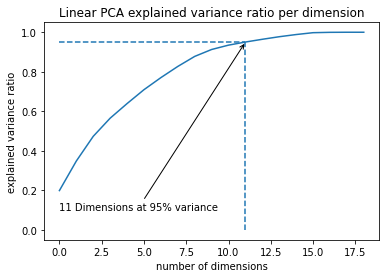

With linear PCA, to preserve 95% of the variance,  11  dimensions are needed.


KernelPCA(kernel='rbf')

With RBF kernel, to preserve 95% of the variance,  291  dimensions are needed.


KernelPCA(kernel='poly')

With 3rd degree polynomial kernel, to preserve 95% of the variance,  106  dimensions are needed.


In [41]:
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

# in order to improve performance and speed in PCA, randomly choose 1% of the data for each of the PCA methods
X_train_pca = X_train[np.random.choice(X_train.shape[0], int(len(df)*0.01), replace=False), :]
X_train_rbf_pca = X_train[np.random.choice(X_train.shape[0], int(len(df)*0.01), replace=False), :]
X_train_poly_pca = X_train[np.random.choice(X_train.shape[0], int(len(df)*0.01), replace=False), :]

# fit a linear PCA function to the selected training data sample and plot variance versus number of dimensions
pca = PCA()
pca.fit(X_train_pca)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)
plt.vlines(11, 0, 0.95, linestyles="dashed")
plt.hlines(0.95, 0, 11, linestyles="dashed")
plt.xlabel("number of dimensions")
plt.ylabel("explained variance ratio")
plt.title("Linear PCA explained variance ratio per dimension")
plt.annotate("11 Dimensions at 95% variance", (11, 0.95), (0, 0.1), arrowprops={"arrowstyle":"->"})
plt.show()
print("With linear PCA, to preserve 95% of the variance, ", np.argmax(cumsum >= 0.95), " dimensions are needed.")

# fit PCA with Gaussian RBF kernel to a sample of the training data and compute minimum dimensions needed
# to preserve 90% of the original variance
rbf_pca = KernelPCA(kernel="rbf")
rbf_pca.fit(X_train_rbf_pca)
rbf_pca_transform = rbf_pca.fit_transform(X_train_rbf_pca)
explained_variance_rbf = np.var(rbf_pca_transform, axis=0)
explained_variance_ratio_rbf = explained_variance_rbf / np.sum(explained_variance_rbf)
cumsum_rbf = np.cumsum(explained_variance_ratio_rbf)
print("With RBF kernel, to preserve 95% of the variance, ", np.argmax(cumsum_rbf >= 0.95), " dimensions are needed.")

# do the same with a 2nd degree polynomial kernel
poly_pca = KernelPCA(kernel="poly")
poly_pca.fit(X_train_poly_pca)
poly_pca_transform = poly_pca.fit_transform(X_train_poly_pca)
explained_variance_poly = np.var(poly_pca_transform, axis=0)
explained_variance_ratio_poly = explained_variance_poly / np.sum(explained_variance_poly)
cumsum_poly = np.cumsum(explained_variance_ratio_poly)
print("With 3rd degree polynomial kernel, to preserve 95% of the variance, ", np.argmax(cumsum_poly >= 0.95), " dimensions are needed.")

In [42]:
# fit and transform linear PCA preserving 95% variance to the train set and transform test set in order
# not to artificially improve test performance
pca_95 = PCA(n_components=11)
X_train = pca_95.fit_transform(X_train)
X_test = pca_95.transform(X_test)

## Fitting and Tuning Models and Evaluating Performance

Now that preprocessing of the data is complete, multiple regression models will be set up from the scikit-learn and the keras libraries, starting with simple linear models and going towards more complex models and a DNN, followed by an ensemble model. Fine-tuning of hyperparameters has been performed iteratively with GridSearch around default values. For evaluation, we will work with 5- or 3-fold cross-validation (depending on the training complexity of the model). Evaluation will be based on (R)MSE, since this gives more weight to greater deviations from the true value as described in the data exploration section above.

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

# instantiate a linear regression object and fit it to the training data
linear = LinearRegression()
linear.fit(X_train, y_train)

# compute cross-validation scores with 5-fold CV and negative RMSE
cv_scores = cross_val_score(linear, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

print("Mean of y_test: ", np.mean(y_test))
print("Mean cross-validation RMSE: ", np.mean(abs(cv_scores)))

LinearRegression()

Mean of y_test:  25.897226264497068
Mean cross-validation RMSE:  11.926546103895795


In [45]:
from sklearn.linear_model import SGDRegressor

# instantiate SGD Regressor object with no regularization (since PCA has already reduced number of dimensions),
# low starting eta and early stopping activated and fit to the training data
sgd = SGDRegressor(max_iter=5000, tol=1e-3, penalty=None, eta0=0.01, early_stopping=True)

sgd.fit(X_train, y_train)

# compute cross-validation scores with 5-fold CV and negative RMSE
cv_scores_sgd = cross_val_score(sgd, X_train, y_train, cv=5, scoring="neg_root_mean_squared_error")

print("Mean of y_train: ", np.mean(y_train))
print("Mean cross-validation RMSE: ", np.mean(abs(cv_scores_sgd)))

SGDRegressor(early_stopping=True, max_iter=5000, penalty=None)

Mean of y_train:  25.9330001014248
Mean cross-validation RMSE:  11.93935544911303


In [46]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# create a parameter grid to search for optimal hyperparameters and instantiate a Decision Tree Regressor object
grid_dt = {
    "ccp_alpha" : [0.0, 0.15, 0.3],
    "min_samples_split" : [2, 4, 8]
}

dt = DecisionTreeRegressor()

# perform grid search with 3-fold CV (for performance reasons) and all cores activated, score on negative RMSE
dt_grid = GridSearchCV(dt, grid_dt, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True, n_jobs=-1)

dt_grid.fit(X_train, y_train)

# print the estimator object for bettermoverview
dt_grid.best_estimator_

# print the best parameters from the grid search and the resulting RMSE
print("Best parameters: ", dt_grid.best_params_)
print("Mean of y_train: ", np.mean(y_train))
print("Cross-validation RMSEs: ", np.mean(abs(dt_grid.cv_results_["mean_test_score"])))

GridSearchCV(cv=3, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'ccp_alpha': [0.0, 0.15, 0.3],
                         'min_samples_split': [2, 4, 8]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

DecisionTreeRegressor(ccp_alpha=0.15)

Best parameters:  {'ccp_alpha': 0.15, 'min_samples_split': 2}
Mean of y_train:  25.9330001014248
Cross-validation RMSEs:  12.778648601008749


In [47]:
from sklearn.svm import LinearSVR
from sklearn.model_selection import RandomizedSearchCV

# create grid with regularization parameter C, instantiate Linear SVR object and compute CV score with 3 folds 
grid_svr = {
    "C" : [0.5, 1, 2, 3]
}

svr = LinearSVR()

svr_grid = RandomizedSearchCV(svr, grid_svr, cv=3, scoring="neg_root_mean_squared_error", return_train_score=True, n_jobs=-1)

svr_grid.fit(X_train, y_train)

svr_grid.best_estimator_

print("Best parameters: ", svr_grid.best_params_)
print("Mean of y_train: ", np.mean(y_train))
print("Cross-validation RMSEs: ", np.mean(abs(svr_grid.cv_results_["mean_test_score"])))

/Users/niklasmarx/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:278: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


RandomizedSearchCV(cv=3, estimator=LinearSVR(), n_jobs=-1,
                   param_distributions={'C': [0.5, 1, 2, 3]},
                   return_train_score=True,
                   scoring='neg_root_mean_squared_error')

LinearSVR(C=1)

Best parameters:  {'C': 1}
Mean of y_train:  25.9330001014248
Cross-validation RMSEs:  12.306699516889118


In [52]:
from tensorflow import keras
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# prepare CV folds, empty list for MSE loss per fold and dictionary for loss per epoch
kfold = KFold(n_splits=3, shuffle=True)
loss_per_fold = []
history_dict = {}

# create two callbacks for saving the model and for early stopping after 5 epochs with no improvement
checkpoint_cb = keras.callbacks.ModelCheckpoint("Flight_ANN.h5")
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True, monitor="loss")

# iterate through folds and train model in maximum 20 epochs in a four-layer DNN; optimize with adam and on MSE
fold = 1
for train, test in kfold.split(X_train, y_train):

    ann_model = keras.models.Sequential([
        keras.layers.Dense(11, input_dim=11, activation='relu'),
        keras.layers.Dense(9, activation='relu'),
        keras.layers.Dense(7, activation='relu'),
        keras.layers.Dense(5, activation='relu'),
        keras.layers.Dense(3, activation='relu'),
        keras.layers.Dense(1)
    ])

    ann_model.compile(loss='mean_squared_error', optimizer='adam')

    history = ann_model.fit(X_train[train], y_train[train], epochs=50, callbacks=[checkpoint_cb, early_stopping_cb])
    history_dict[fold] = history.history.values()
    
    # generate loss metric and put in empty list created before
    scores = np.sqrt(ann_model.evaluate(X_train[test], y_train[test], verbose=0))
    print(f'RMSE for fold {fold}: {ann_model.metrics_names} of {scores}')
    loss_per_fold.append(scores)

    fold += 1


Epoch 1/50
9449/9449 [==============================] - 9s 865us/step - loss: 204.3919 0s - loss: 205.0
Epoch 2/50
9449/9449 [==============================] - 8s 868us/step - loss: 138.6592
Epoch 3/50
9449/9449 [==============================] - 9s 968us/step - loss: 139.0138
Epoch 4/50
9449/9449 [==============================] - 11s 1ms/step - loss: 137.0314
Epoch 5/50
9449/9449 [==============================] - 9s 952us/step - loss: 135.1193
Epoch 6/50
9449/9449 [==============================] - 9s 900us/step - loss: 136.5059
Epoch 7/50
9449/9449 [==============================] - 8s 868us/step - loss: 135.8431
Epoch 8/50
9449/9449 [==============================] - 8s 864us/step - loss: 134.2678 1s - loss: 134 - ETA: 0s 
Epoch 9/50
9449/9449 [==============================] - 8s 860us/step - loss: 134.6849
Epoch 10/50
9449/9449 [==============================] - 8s 862us/step - loss: 131.4505
Epoch 11/50
9449/9449 [==============================] - 9s 976us/step - loss: 132.4163

Text(0.5, 1.0, 'MSE on Fold 1')

Text(0.5, 1.0, 'MSE on Fold 2')

Text(7, 400, 'Note early stopping after 16 epochs')

Text(0.5, 1.0, 'MSE on Fold 3')

[Text(0.5, 15.0, 'Epochs')]

[Text(27.0, 0.5, 'MSE')]

[Text(27.0, 0.5, 'MSE')]

[Text(27.0, 0.5, 'MSE')]

The mean training RMSE across folds is: 11.824562890800246


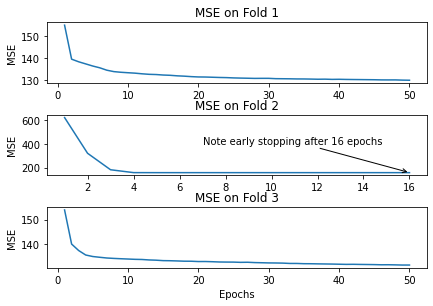

In [54]:
# create dataframe with loss values per epoch per fold
history_df = pd.DataFrame(history_dict.values())

# plot MSE per epoch separately for all three folds
fig, ax = plt.subplots(3)
fig.tight_layout()
ax[0].set_title("MSE on Fold 1")
ax[0].plot(range(1, 51), history_df.loc[0,0])
ax[1].set_title("MSE on Fold 2")
ax[1].plot(range(1, 17), history_df.loc[1,0])
ax[1].annotate("Note early stopping after 16 epochs", (16, 158), (7, 400), arrowprops={"arrowstyle":"->"})
ax[2].set_title("MSE on Fold 3")
ax[2].plot(range(1, 51), history_df.loc[2,0])
ax[2].set(xlabel="Epochs")

for ax in ax.flat:
    ax.set(ylabel="MSE")

# print mean RMSE across folds for comparability
print("The mean training RMSE across folds is: "+str(np.mean(loss_per_fold)))

## Ensemble model to attempt a better solution

Despite the performance increase achieved by fine-tuning the models iteratively with hyperparameter tuning and grid search and going towards more complex models (especially the well-performing DNN above), we now want to try an ensemble model that combines multiple individual models, in this case a random forest model combining multiple decision tree regressors that ideally output uncorrelated trees and should hopefully improve upon the relatively low performance of the single decision tree seen above.

In [55]:
from sklearn.ensemble import RandomForestRegressor

# create grid values for minimum number of samples per split and number of estimators used
grid_rf = {
    "min_samples_split" : [4, 8, 12],
    "n_estimators" : [100, 200, 300]
}

# instantiate Random Forest Regressor object with minimum impurity decrease per split of 1% and fit to training data
rf = RandomForestRegressor(n_jobs=-1, min_impurity_decrease = 0.01)

rf_grid = GridSearchCV(rf, grid_rf, cv = 3, scoring = "neg_root_mean_squared_error", return_train_score = True)

rf_grid.fit(X_train, y_train)

rf_grid.best_estimator_

print("Best parameters: ", rf_grid.best_params_)
print("Mean of y_train: ", np.mean(y_train))
print("Cross-validation RMSEs: ", np.mean(abs(rf_grid.cv_results_["mean_test_score"])))

GridSearchCV(cv=3,
             estimator=RandomForestRegressor(min_impurity_decrease=0.01,
                                             n_jobs=-1),
             param_grid={'min_samples_split': [4, 8, 12],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True, scoring='neg_root_mean_squared_error')

RandomForestRegressor(min_impurity_decrease=0.01, min_samples_split=4,
                      n_estimators=300, n_jobs=-1)

Best parameters:  {'min_samples_split': 4, 'n_estimators': 300}
Mean of y_train:  25.9330001014248
Cross-validation RMSEs:  11.013329278757375


As we can see from the results, the ensemble model in the form of a random forest outperformed even the DNN after hyperparameter tuning and might even be further improved in the future with different hyperparameters like more estimators used. This performance is especially striking, since the single decision tree regressor achieved a performance worse than simpler models, which might be due to the shape of the feature spaces in the data that cannot be well separated by rectangular tree-spaces. The DNN stopped training early in one training fold and did not significantly improve performance on the others as seen in the visualization above, thus we can assume that this model could only potentially be improved with more or different layers or a different activation function. In general, the linear models (including also the LinearSVR model) did not perform too well, thus besides the well-performing ensemble model and DNN, other non-linear models might be worth exploring.

## Evaluation on the test set

From the cross-validation results of the training set, we saw that the random forest ensemble model performed best, achieving a cross-validation RMSE across three folds of 11.01 (minutes). We thus want to evaluate this model on the 20% of the data that we held back from all models so far to see if the good performance might be caused by overfitting to the training data (as may be the case with more complex models) or if the performance is similar or even better on the test set, which might be a sign of underfitting.

In [78]:
# finally, we predict the test set values with the best model from our previous tries and calculate test RMSE
y_pred = rf_grid.predict(X_test)

print("Test set RMSE of Random Forest Regressor: "+ str(np.sqrt(mean_squared_error(y_test, y_pred))))

Test set RMSE of Random Forest Regressor: 11.044520236642825


Text(0.5, 0, 'Measured taxi minutes')

Text(0, 0.5, 'Predicted taxi minutes')

Text(0.5, 1.0, 'True y-labels vs predicted y-labels RF')

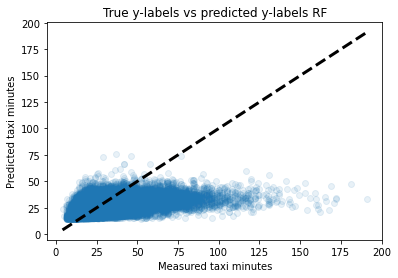

In [86]:
# plot the true target values for the test set versus the estimated values with the best model
plt.scatter(y_test, y_pred, alpha=0.1)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "k--", lw=3)
plt.xlabel("Measured taxi minutes")
plt.ylabel("Predicted taxi minutes")
plt.title("True y-labels vs predicted y-labels RF")

## Conclusion and Outlook

The performance on the test set was slightly worse at 11.04 minutes (0.3 minutes more than on the training CV). This shows that the ensemble model has likely not not been overfitting the training data. The final visualization then shows what we had already expected from the feature and correlation visualization section: While for the vast majority of flights which have taxi times within the bell curve seen earlier, the predictions are close to the true target value, the flights which fall in the long upper tail of the distribution are further from the actual values the higher the actual taxi time is. Thus, for these extreme cases with few data points, the model performance could be improved with more complex non-linear models, but only in a careful manner not to overfit to these few datapoints and risk the loss of generalization power.

Summarizing this work, we have seen that visualizing the distribution of the target variable can help to interpret the final model performance. Also, setting and testing for hypotheses about the distribution and correlation of variables helps to uncover potential data biases the models might have to deal with. In terms of models, we have seen that hyperparameter tuning can be important (as seen in the fact that the best parameters in GridSearch were often not the default values of the models and constant iterative adjustments of the hyperparameters have brought model improvements) and that ensemble models combining rather simple single models can perform better that more complex standalone models. When designing and tuning models, implementing early stopping (as seen in the SGDRegressor and the DNN) can avoid suboptimal results and a cross-validation can give a more realistic idea of performance than evaluation only on one test set (as seen in the performance variations of the DNN folds).

In terms of real-world implications of this model, an RMSE of 11 means that the model can predict total taxi times within 11 minutes of their actual values on average, which could improve flight planning for airlines and save airlines significant fuel cost: One minute of taxiing in an Airbus A320 consumes 14.4 kg of jet fuel (Khadilkar & Balakrishnan, 2011), costing USD0.55 per kg (IATA, 2021), thus USD7.92 could be saved per taxi minute and flight, as well as 45kg of carbon dioxide (EESI, 2019).

## References
1. Khadilkar & Balakrishnan, 2011: Estimation of Aircraft Taxi-out Fuel Burn using Flight Data Recorder Archives, https://web.mit.edu/hamsa/www/pubs/KhadilkarBalakrishnanGNC2011.pdf
2. IATA, 2021, Fuel Price Monitor: https://www.iata.org/en/publications/economics/fuel-monitor/
3. EESI, 2019, Fact Sheet | The Growth in Greenhouse Gas Emissions from Commercial Aviation, https://www.eesi.org/papers/view/fact-sheet-the-growth-in-greenhouse-gas-emissions-from-commercial-aviation
4. Code references for different functions and dfSelector class: Géron, Aurelien: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow (Second Edition), 2019
5. Documentation for scikit-learn classes: https://scikit-learn.org/stable/
6. Documentation for visualizations: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.plot.html
7. BTS (Bureau of Transportation Statistics), 2019 (needs to be configured before download), https://www.transtats.bts.gov/Tables.asp?QO_VQ=EFD&QO_anzr=Nv4yv0r%FDb0-gvzr%FDcr4s14zn0pr%FDQn6n&QO_fu146_anzr=b0-gvzr
8. BTS Airport code coordinate lookup: https://www.transtats.bts.gov/Tables.asp?QO_VQ=IMI&QO_anzr=N8vn6v10%FDf722146%FDgnoyr5&QO_fu146_anzr=N8vn6v10%FDf722146%FDgnoyr5
9. Saxena, 2020: Here’s All you Need to Know About Encoding Categorical Data (with Python code), https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/

## Appendix: Data Field Descriptions from BTS website

- DayofMonth: Day of Month
- DayOfWeek: Day of Week
- OP Unique Carrier: Code assigned by IATA and commonly used to identify a carrier. As the same code may have been assigned to different carriers over time, the code is not always unique. For analysis, use the Unique Carrier Code.
- OP Carrier Fl Num: Flight Number
- Origin: Origin Airport
- OriginWac: Origin Airport, World Area Code
- Dest: Destination Airport
- DestWac: Destination Airport, World Area Code
- CRSDepTime: CRS Departure Time (local time: hhmm)
- TaxiOut: Taxi Out Time, in Minutes
- TaxiIn: Taxi In Time, in Minutes
- CRSArrTime: CRS Arrival Time (local time: hhmm)
- Cancelled: Cancelled Flight Indicator (1=Yes)
- Diverted: Diverted Flight Indicator (1=Yes)
- CRSElapsedTime: CRS Elapsed Time of Flight, in Minutes
